<a href="https://colab.research.google.com/github/velasoka-repo/EVA4/blob/master/Session-5/EVA4_S5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Github Link](https://github.com/velasoka-repo/EVA4/blob/master/Session-5/EVA4_S5_4.ipynb)

#Target:
1. Add **Data Augmentation**
2. Improve Test Accuracy

#Results:
1. Parameters: `9,866`
2. Best Training Accuracy: `99.23%` 
3. Best Test Accuracy: `99.44%`
4. Epochs: 15

# Analysis: (Net1 without dropout)
1. Using Augmentation we can achieve `99.44%` accuracy
2. Train Accuracy is increasing for each epoch
3. Seems to be good model(Train: `99.23%`, Test: `99.29%`) but Accuracy is not stable (Accuracy is slightly going UP & DOWN 0.5%)

- - -

#Results:
1. Parameters: `9,866`
2. Best Training Accuracy: `99.01%` 
3. Best Test Accuracy: `99.42%`
4. Epochs: 15

# Analysis: (Net2 with 0.1 dropout)
1. Using Augmentation we can achieve `99.42%` accuracy
2. Train Accuracy is increasing for each epoch
3. Test Accuracy is increasing stable (No DOWN in accuracy)
4. Seeing bit of underfitting(Train: `99.01%`, Test: `99.42%`)

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Data Augmentation & Visualize

In [0]:
def visualize(data, heading):
  print("\n")
  print(heading.rjust(50, ' '))
  print("-"*140)
  plt.figure(figsize=(20, 11))
  for i in range(1, 181):
    ax = plt.subplot(10, 18, i)
    img, title = data[i-1];
    plt.axis('off')
    if i <= 18:
      ax.set_title(title)
    plt.imshow(img)
  plt.show()

#### Pytorch Transformation
* Analyzing all Transformation to Choose which transform suites best

In [220]:
#random_rotate = transforms.RandomRotation(degrees=(-10, 20), fill=(0, ))
random_rotate = transforms.RandomRotation(degrees=(-10, 20), fill=(0, ))
scale = transforms.Scale(size=15)
center_crop = transforms.CenterCrop(size=20)
resize = transforms.Resize(size=10)
random_apply = transforms.RandomApply(transforms=(random_rotate, scale, center_crop, resize), p=0.5) #picks any transforms randomly
random_choice = transforms.RandomChoice(transforms=(random_rotate, scale, center_crop, resize)) 
random_order = transforms.RandomOrder(transforms=(random_rotate, scale, center_crop, resize))
random_crop = transforms.RandomCrop(size=20)
random_hflip = transforms.RandomHorizontalFlip(p=0.7)
random_vflip = transforms.RandomVerticalFlip(p=0.7)
random_resized_crop = transforms.RandomResizedCrop(size=20)
five_crop = transforms.FiveCrop(size=25)
ten_crop = transforms.TenCrop(size=25)
color_jitter = transforms.ColorJitter(brightness=0.9, contrast=0.1, saturation=0.5, hue=0.2)
random_affine = transforms.RandomAffine(degrees=(-10, 20), scale=(1,2))
gray_scale = transforms.Grayscale(num_output_channels=1)
random_gray_scale = transforms.RandomGrayscale(p=0.9)
random_perspective = transforms.RandomPerspective(distortion_scale=0.8, p=0.7)
to_tensor = transforms.ToTensor()
random_erasing = transforms.RandomErasing(p=0.8, scale=(0.01, 0.23), ratio=(0.2, 0.3), value=0.1) #this can be applied after ToTensor

def rand_erasing_fn(x):
  x = to_tensor(x)
  x = random_erasing(x)
  return x.squeeze()

transform_fn = ((random_rotate, "R-Rotate"), 
                (scale, "Scale"), 
                (center_crop, "C-Crop"), 
                (resize, "Resize"), 
                (random_apply, "R-Apply"), 
                (random_choice, "R-Choice"), 
                 (random_order, "R-Order"), 
                (random_crop, "R-Crop"), 
                (random_hflip, "HFlip"), 
                 (random_vflip, "VFlip"), 
                (random_resized_crop, "RR-Crop"), 
                 (color_jitter, "Jitter"), 
                (random_affine, "R-Affine"), 
                 (gray_scale, "Gray-S"), 
                (random_gray_scale, "R-GScale"), 
                (random_perspective, "R-Perspec"), 
                (rand_erasing_fn, "R-Erase"))

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")




                           Train Data Augmentation
--------------------------------------------------------------------------------------------------------------------------------------------


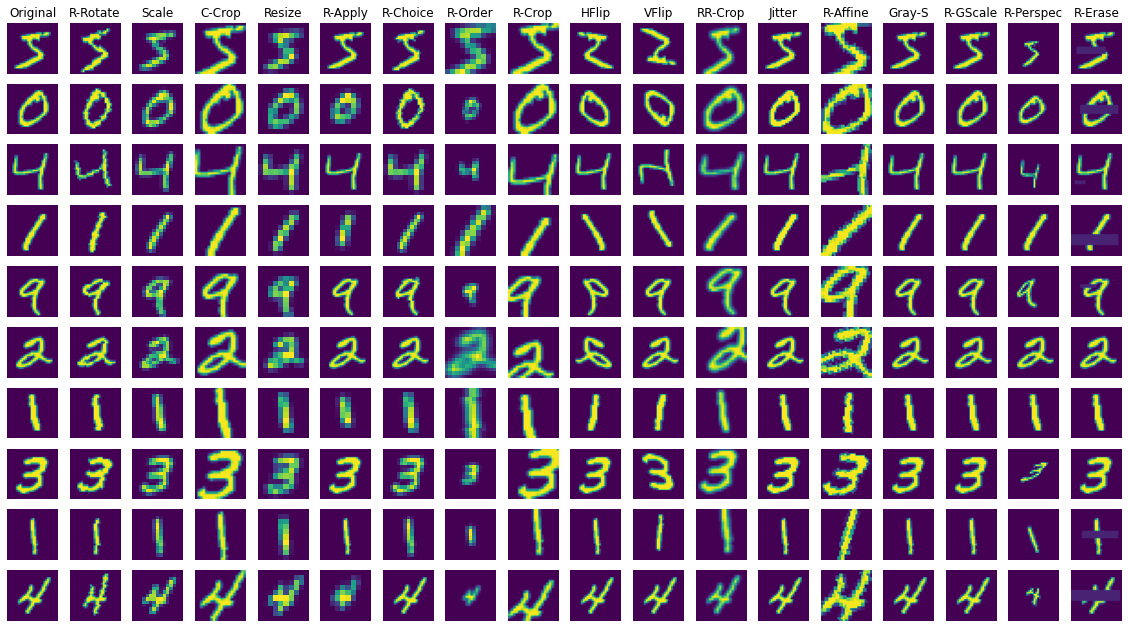

In [221]:
def apply_transformation(data):
  augment_data = []
  for i in range(10):
    t = data[i][0]
    augment_data.append((t, "Original"))
    for fn, title in transform_fn:
      a = fn(t)
      augment_data.append((a, title))

  return augment_data


train_data = datasets.MNIST('./data', train=True, download=True)
train_data_aug = apply_transformation(train_data)

visualize(train_data_aug, "Train Data Augmentation")

## Data Transformations

Applying following three transformation

1.   Compose - group multiple transform into sequential transform
2.   ToTensor - Convert numpy | PILImage to tensor and convert range between 0-1 
`(i.e) array/255`
3. Normalize - input data(train & test) is normalized besed on `mean` & `std` 
`(i.e) (i'th value - mean)/std => final i'th range becomes (-1, 1)`
4. Slight RandomRotate (right to left rotate)

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
    random_rotate,
    # color_jitter,
    # center_crop,
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [248]:
SEED = 6

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Training and Testing

In [0]:
def train(model, device, train_loader, optimizer, epoch, train_repo):
  train_losses, train_acc = train_repo
  model.train()
  pbar = tqdm(iterable=train_loader, total=len(train_loader), position=0)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_repo):
    test_losses, test_acc = test_repo
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Draw Accuracy Graph

In [0]:
def draw_accuracy(train_repo, test_repo):
  train_losses, train_acc = train_repo
  test_losses, test_acc = test_repo
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

# Training Model (1)

In [0]:
class Net(nn.Module):
    def __init__(self, fm_size):
        super(Net, self).__init__()
        self.fm_size = fm_size
        self.num_classes = 10
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 24

        # self.fm_size *=2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.2), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.2)),
        ) # output_size = 22
        
        self.fm_size = int(self.fm_size*1.2)
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size/1.2), kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size/1.2)),
        ) # output_size = 11

        self.fm_size = int(self.fm_size/1.2)
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 9

        # self.fm_size *=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.5), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.5)),
        ) # output_size = 7

        self.fm_size = int(self.fm_size*1.5)
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.num_classes, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.num_classes),
        ) # output_size = 7

        self.avg = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_classes, out_channels=self.num_classes, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)

        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.avg(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model Params

In [252]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Available device: {device}")
model = Net(14).to(device)
summary(model, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
            Conv2d-4           [-1, 14, 24, 24]           1,764
              ReLU-5           [-1, 14, 24, 24]               0
       BatchNorm2d-6           [-1, 14, 24, 24]              28
            Conv2d-7           [-1, 16, 22, 22]           2,016
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 13, 11, 11]             208
             ReLU-12           [-1, 13, 11, 11]               0
      BatchNorm2d-13           [-1, 13, 11, 11]              26
           Conv2

# Train and test our model (Net - without dropout)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.0869469866156578 Batch_id=468 Accuracy=87.25: 100%|██████████| 469/469 [00:11<00:00, 40.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0844, Accuracy: 9798/10000 (97.98%)

EPOCH: 2


Loss=0.03427724540233612 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:11<00:00, 40.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9863/10000 (98.63%)

EPOCH: 3


Loss=0.06417156010866165 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:11<00:00, 41.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.03141835704445839 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:11<00:00, 41.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.02521357871592045 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:11<00:00, 41.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.03002947010099888 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:11<00:00, 41.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


Loss=0.04144526645541191 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:10<00:00, 42.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.013944372534751892 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:11<00:00, 41.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.010532413609325886 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:10<00:00, 42.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.1083291694521904 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:10<00:00, 42.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.03400683403015137 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:11<00:00, 41.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.01221667230129242 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:11<00:00, 42.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.03267756104469299 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:11<00:00, 42.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.006970594171434641 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:11<00:00, 42.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.014496912248432636 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 41.92it/s]



Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

---------------------------------------------------------------------------


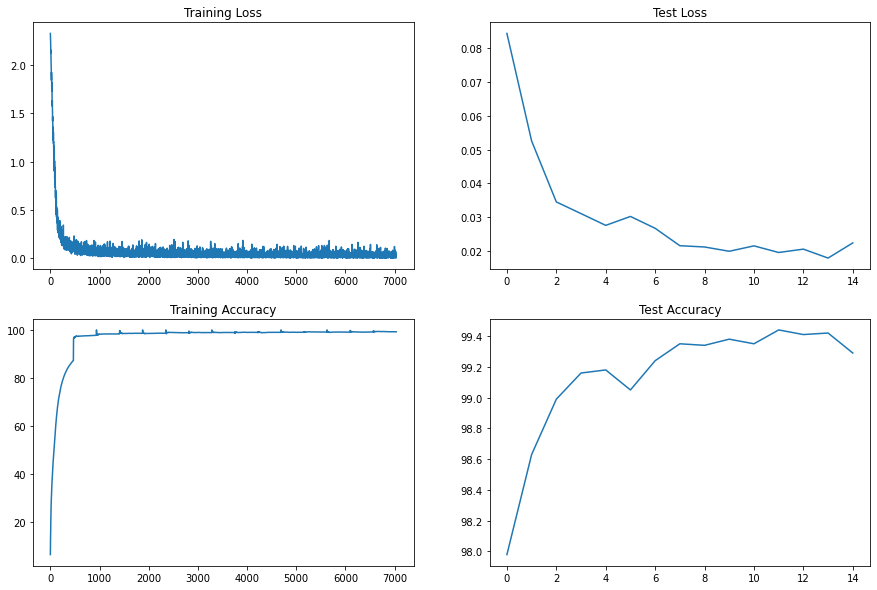

In [201]:
model =  Net(14).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
test_repo = ([], [])
train_repo = ([], [])
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_repo)
    test(model, device, test_loader, test_repo)

print("-"*75)
draw_accuracy(train_repo, test_repo)

# Training Model (2)

In [0]:
class Net2(nn.Module):
    def __init__(self, fm_size, dropout_value=0.25):
        super(Net2, self).__init__()
        self.fm_size = fm_size
        self.num_classes = 10
        self.dropout_value = dropout_value
        self.dropout = nn.Dropout2d(self.dropout_value)
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 24

        # self.fm_size *=2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.2), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.2)),
        ) # output_size = 22
        
        self.fm_size = int(self.fm_size*1.2)
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size/1.2), kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size/1.2)),
        ) # output_size = 11

        self.fm_size = int(self.fm_size/1.2)
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 9

        # self.fm_size *=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.5), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.5)),
        ) # output_size = 7

        self.fm_size = int(self.fm_size*1.5)
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.num_classes, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.num_classes),
        ) # output_size = 7

        self.avg = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_classes, out_channels=self.num_classes, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        # x = self.dropout(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.avg(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model Params

In [203]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Available device: {device}")
model = Net2(14, 0.1).to(device)
summary(model, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
            Conv2d-4           [-1, 14, 24, 24]           1,764
              ReLU-5           [-1, 14, 24, 24]               0
       BatchNorm2d-6           [-1, 14, 24, 24]              28
            Conv2d-7           [-1, 16, 22, 22]           2,016
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        Dropout2d-10           [-1, 16, 22, 22]               0
        MaxPool2d-11           [-1, 16, 11, 11]               0
           Conv2d-12           [-1, 13, 11, 11]             208
             ReLU-13           [-1, 13, 11, 11]               0
      BatchNorm2

# Train and test our model (Net2 - has 0.1 dropout)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.09910378605127335 Batch_id=468 Accuracy=86.40: 100%|██████████| 469/469 [00:11<00:00, 41.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0921, Accuracy: 9764/10000 (97.64%)

EPOCH: 2


Loss=0.053960684686899185 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:11<00:00, 41.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9842/10000 (98.42%)

EPOCH: 3


Loss=0.03681391850113869 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:11<00:00, 41.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.04838135465979576 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:11<00:00, 41.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.035580649971961975 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:11<00:00, 41.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.03660208359360695 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:11<00:00, 41.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.0601760596036911 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:11<00:00, 42.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.031872596591711044 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:11<00:00, 42.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.06373367458581924 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:11<00:00, 41.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.024969106540083885 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:11<00:00, 41.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.08063890039920807 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:11<00:00, 41.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.022794349119067192 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:11<00:00, 42.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.07103078812360764 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:11<00:00, 41.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9918/10000 (99.18%)

EPOCH: 14


Loss=0.04946766793727875 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:11<00:00, 42.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.0727667286992073 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:11<00:00, 42.46it/s]



Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.42%)

---------------------------------------------------------------------------


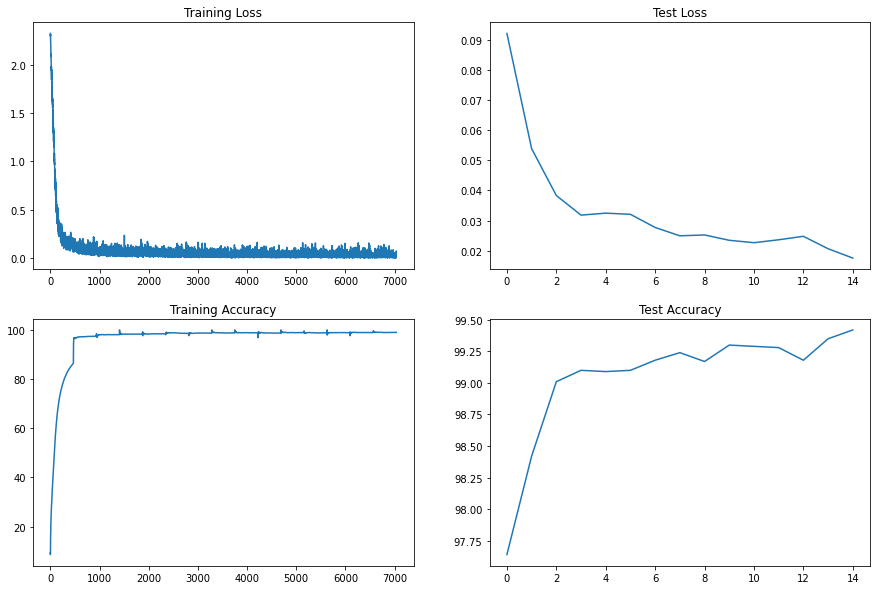

In [204]:
model =  Net2(14, 0.1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
test_repo = ([], [])
train_repo = ([], [])
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_repo)
    test(model, device, test_loader, test_repo)

print("-"*75)
draw_accuracy(train_repo, test_repo)